# Modeling transits from TESS observation with `Lightkurve` and `Pyaneti`

In [1]:
import numpy as np

from astropy.table import Table
from astropy.time import Time
from astropy import units as u

from importlib import reload

import lightkurve as lk
import lightkurve_ext_pyaneti as lkep

#### Set the appropriate directory for your `Pyaneti` installation
<span style="background-color: yellow;">Enter your values</span>

In [2]:
# Per installation config
download_dir = "data"  # for Lightkurve download, None to use the Lightkurve default
pyaneti_home_dir = r"L:\home\orionlee\dev\pyaneti"


#### Specify the TESS Lightcurve data to download
<span style="background-color: yellow;">Enter your values</span>

In [3]:
reload(lkep)

# sector 1 is the data used by Pyaneti documentation, which references
# [Gandolfi et al., 2018.](https://arxiv.org/abs/1809.07573)
#
tic, sector = 261136679, [1]  # pi Men

cadence = "short"  # short: use TESS 2-minute data only

In [4]:
sr = lk.search_lightcurve(f"TIC{tic}", mission="TESS", cadence=cadence)
sr

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 01,2018,SPOC,120,261136679,0.0,"G011183 , G011132 , G011048 , G011250"
1,TESS Sector 04,2018,SPOC,120,261136679,0.0,"G011183 , G011132 , G011048 , G011250"
2,TESS Sector 08,2019,SPOC,120,261136679,0.0,"G011183 , G011132 , G011048 , G011250"
3,TESS Sector 11,2019,SPOC,120,261136679,0.0,"G011183 , G011132 , G011048 , G011250"
4,TESS Sector 12,2019,SPOC,120,261136679,0.0,"G011183 , G011132 , G011048 , G011250"
5,TESS Sector 13,2019,SPOC,120,261136679,0.0,"G011183 , G011132 , G011048 , G011250"
6,TESS Sector 27,2020,SPOC,120,261136679,0.0,"G03272 , G03278 , G03227 , G03035 , G03106 , G03251"
7,TESS Sector 28,2020,SPOC,120,261136679,0.0,"G03272 , G03278 , G03227 , G03035 , G03106 , G03251"
8,TESS Sector 31,2020,SPOC,120,261136679,0.0,"G03272 , G03278 , G03227 , G03035 , G03106 , G03251"


LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 261136679" SECTOR=1 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


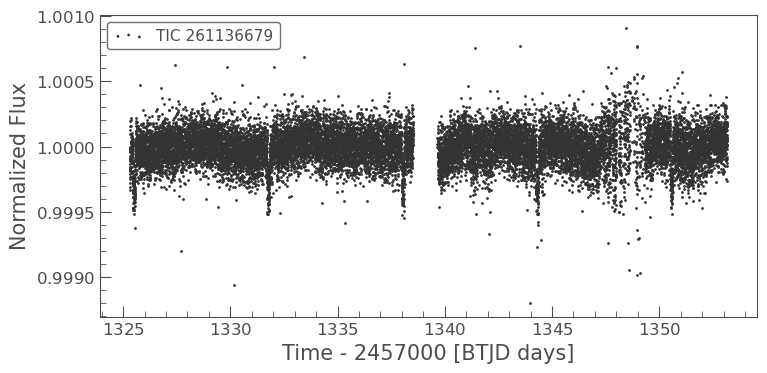

In [7]:
# Download the specified sector(s)
lcc = sr[np.in1d(sr.table["sequence_number"], sector)].download_all(download_dir=download_dir)
print(lcc);
lc = lcc.stitch();
lc.scatter();

#### Specify the transits identified
<span style="background-color: yellow;">Enter your values</span>
- to supply the relevant portions of the lightcurves for `Pyaneti` modeling
- the parameters are used for other fitting purposes too

In [5]:
reload(lkep)

transit_specs = [
    dict(epoch=2365.964, duration_hr=3.01594357498873, period=6.26781105588686, 
         surround_time=0.5,  # additional time surrounding each transit to keep (as out of transits data), defaulted to 2 * duration
         epoch_error=None,  # used for modeling fitting to define `Pyaneti` `min_t0` and `max_t0`
         period_error=0.1,  # used for modeling fitting to define `Pyaneti` `min_P` and `max_P`
         transit_depth_percent=0.03,  # for planet radius estimate, used in modeling
         label="TOI 144.01"  # a label
         )
]

# the model skeleton to be used, found in pyaneti_templates/ subdirectory
modeling_template = "1planet_circular_orbit"  # "1planet_circular_orbit_matched_rho"

# alias is used as directory name base for the modeling input / output
# if you model the same target with different parameters, you can set a different alias 
# to store the modeling input/output in different directories
alias = f"TIC{tic}"  # f"TIC{tic}_matched_rho"

# specify the directories of modeling input/output
pti_env = lkep.PyanetiEnv(pyaneti_home_dir, alias, sector)

Processed LC for Pyaneti input
L:\home\orionlee\dev\pyaneti\inpy\TIC261136679\TIC261136679_lc_s01.dat


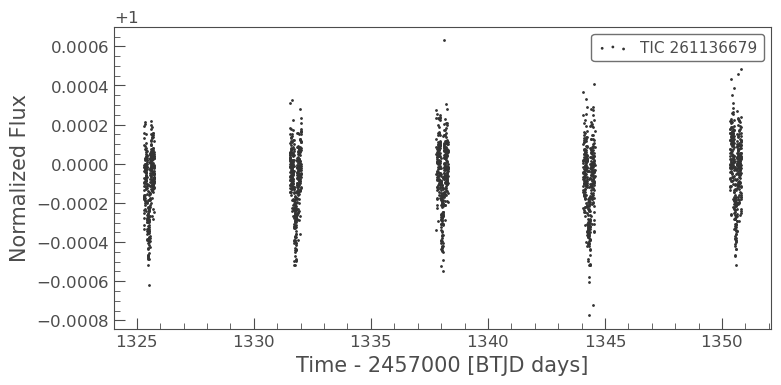

In [8]:
# Create truncated and processed Lightcurve data to feed to Pyaneti
lc_pyaneti_dat_filepath, lc_processed = lkep.to_pyaneti_dat(lc, transit_specs, pti_env, return_processed_lc=True)
print("Processed LC for Pyaneti input")
print(lc_pyaneti_dat_filepath)
lc_processed.scatter();

window length:  0.4986046504418482
cadence (min):  1.9999740524144727


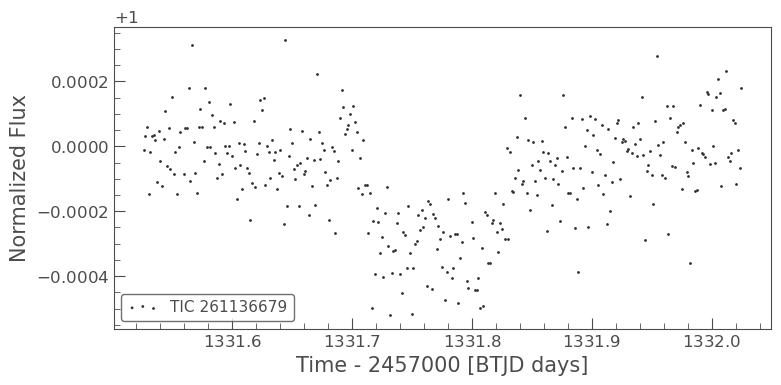

In [13]:
# Zoom-in to one transit for reviewing the result

lc_trunc = lc_processed.truncate(1330, 1334)

print("window length: ", lc_trunc.time[-1] - lc_trunc.time[0])
print("cadence (min): ", 24 * 60 * np.nanmedian(np.diff(lc_trunc.time)))

lc_trunc.scatter();

#### Obtain and estimate stellar parameters
<span style="background-color: yellow;">Inspect the values to see if they are reasonable, override them if needed</span>

In [9]:
reload(lkep)

# get TIC stellar parameters from MAST database
meta = lkep.catalog_info_TIC(tic)  
# estimates for limb darkening quadradtic coefficients
q1_q2 = lkep.get_limb_darkening_params(meta) 
# estimate Rp/R*
r_planet_dict = lkep.estimate_planet_radius_in_r_star(meta["rad"], transit_specs[0]["transit_depth_percent"] / 100)
# estimate a/R*
a_planet_dict = lkep.estimate_orbital_distance_in_r_star(meta)


meta["ID"], q1_q2, r_planet_dict, a_planet_dict, 'mass*', meta['mass'], meta['e_mass'], 'radius*', meta['rad'], meta['e_rad'], 'Teff*', meta['Teff'], meta['e_Teff'], "rho*:", meta['rho'], meta['e_rho']


('261136679',
 {'q1': 0.3345, 'q2': 0.2282, 'e_q1': 0.12, 'e_q2': 0.08},
 {'r_planet_in_r_star': 0.0173,
  'r_planet_in_r_star_min': 0.0,
  'r_planet_in_r_star_max': 0.0346},
 {'a_min': 2.0, 'a_max': 30.0},
 'mass*',
 1.1,
 0.140389,
 'radius*',
 1.14889,
 0.0450252,
 'Teff*',
 5992.1,
 103.582,
 'rho*:',
 0.725369,
 0.141498)

##### Override the stellar parameters if needed
- e.g., ExoFOP may hve more updated information. Or one might get better parameters from Gaia EDR3

In [57]:
# Override the parameters if needed
# meta["rho"] = 1.02277
# meta["e_rho"] = 0.199512

#### Generate `input_fit.py`

In [15]:
reload(lkep)

input_fit_filepath = lkep.create_input_fit(modeling_template, tic, alias, pti_env, lc_processed, transit_specs, meta, q1_q2, r_planet_dict, a_planet_dict,
    write_to_file=True, return_content=False)

lkep.display_pyaneti_input_py_location(input_fit_filepath)

In [16]:
reload(lkep)
lkep.display_pyaneti_instructions(pti_env)


Run `Pyaneti` to do the modeling:
```
cd L:\home\orionlee\dev\pyaneti
python pyaneti.py  TIC261136679
```
    

### Model result

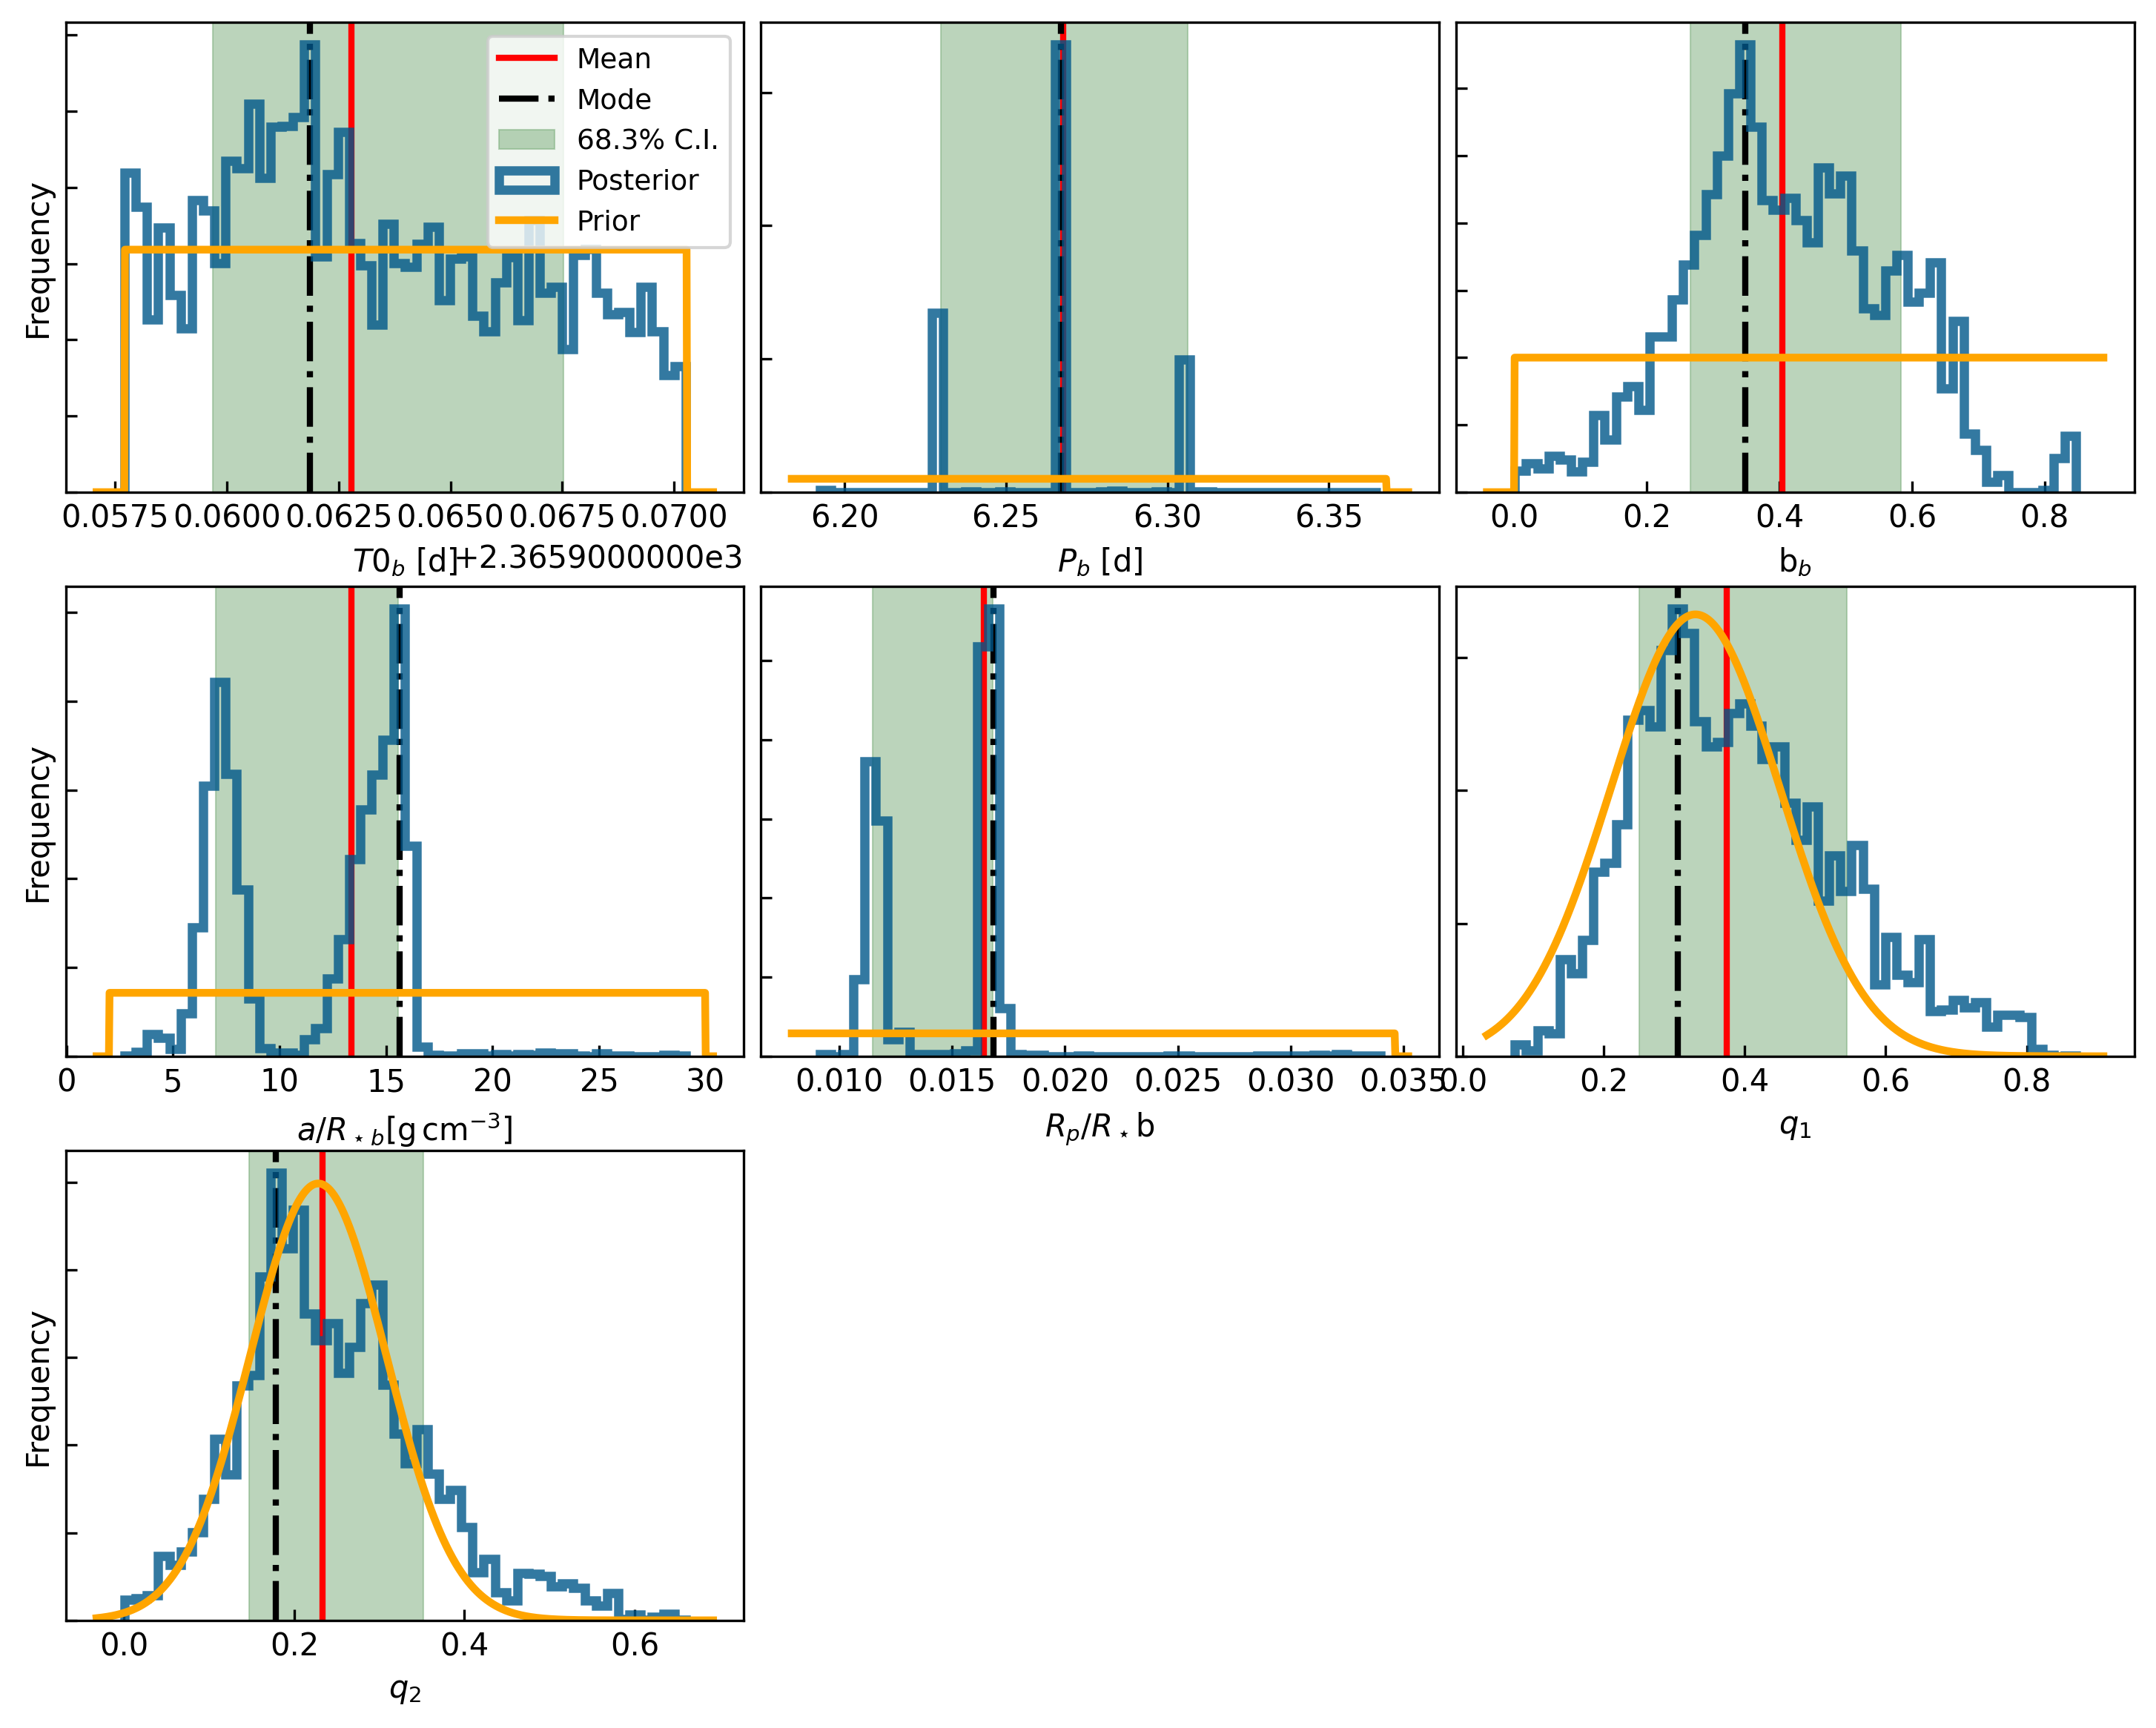

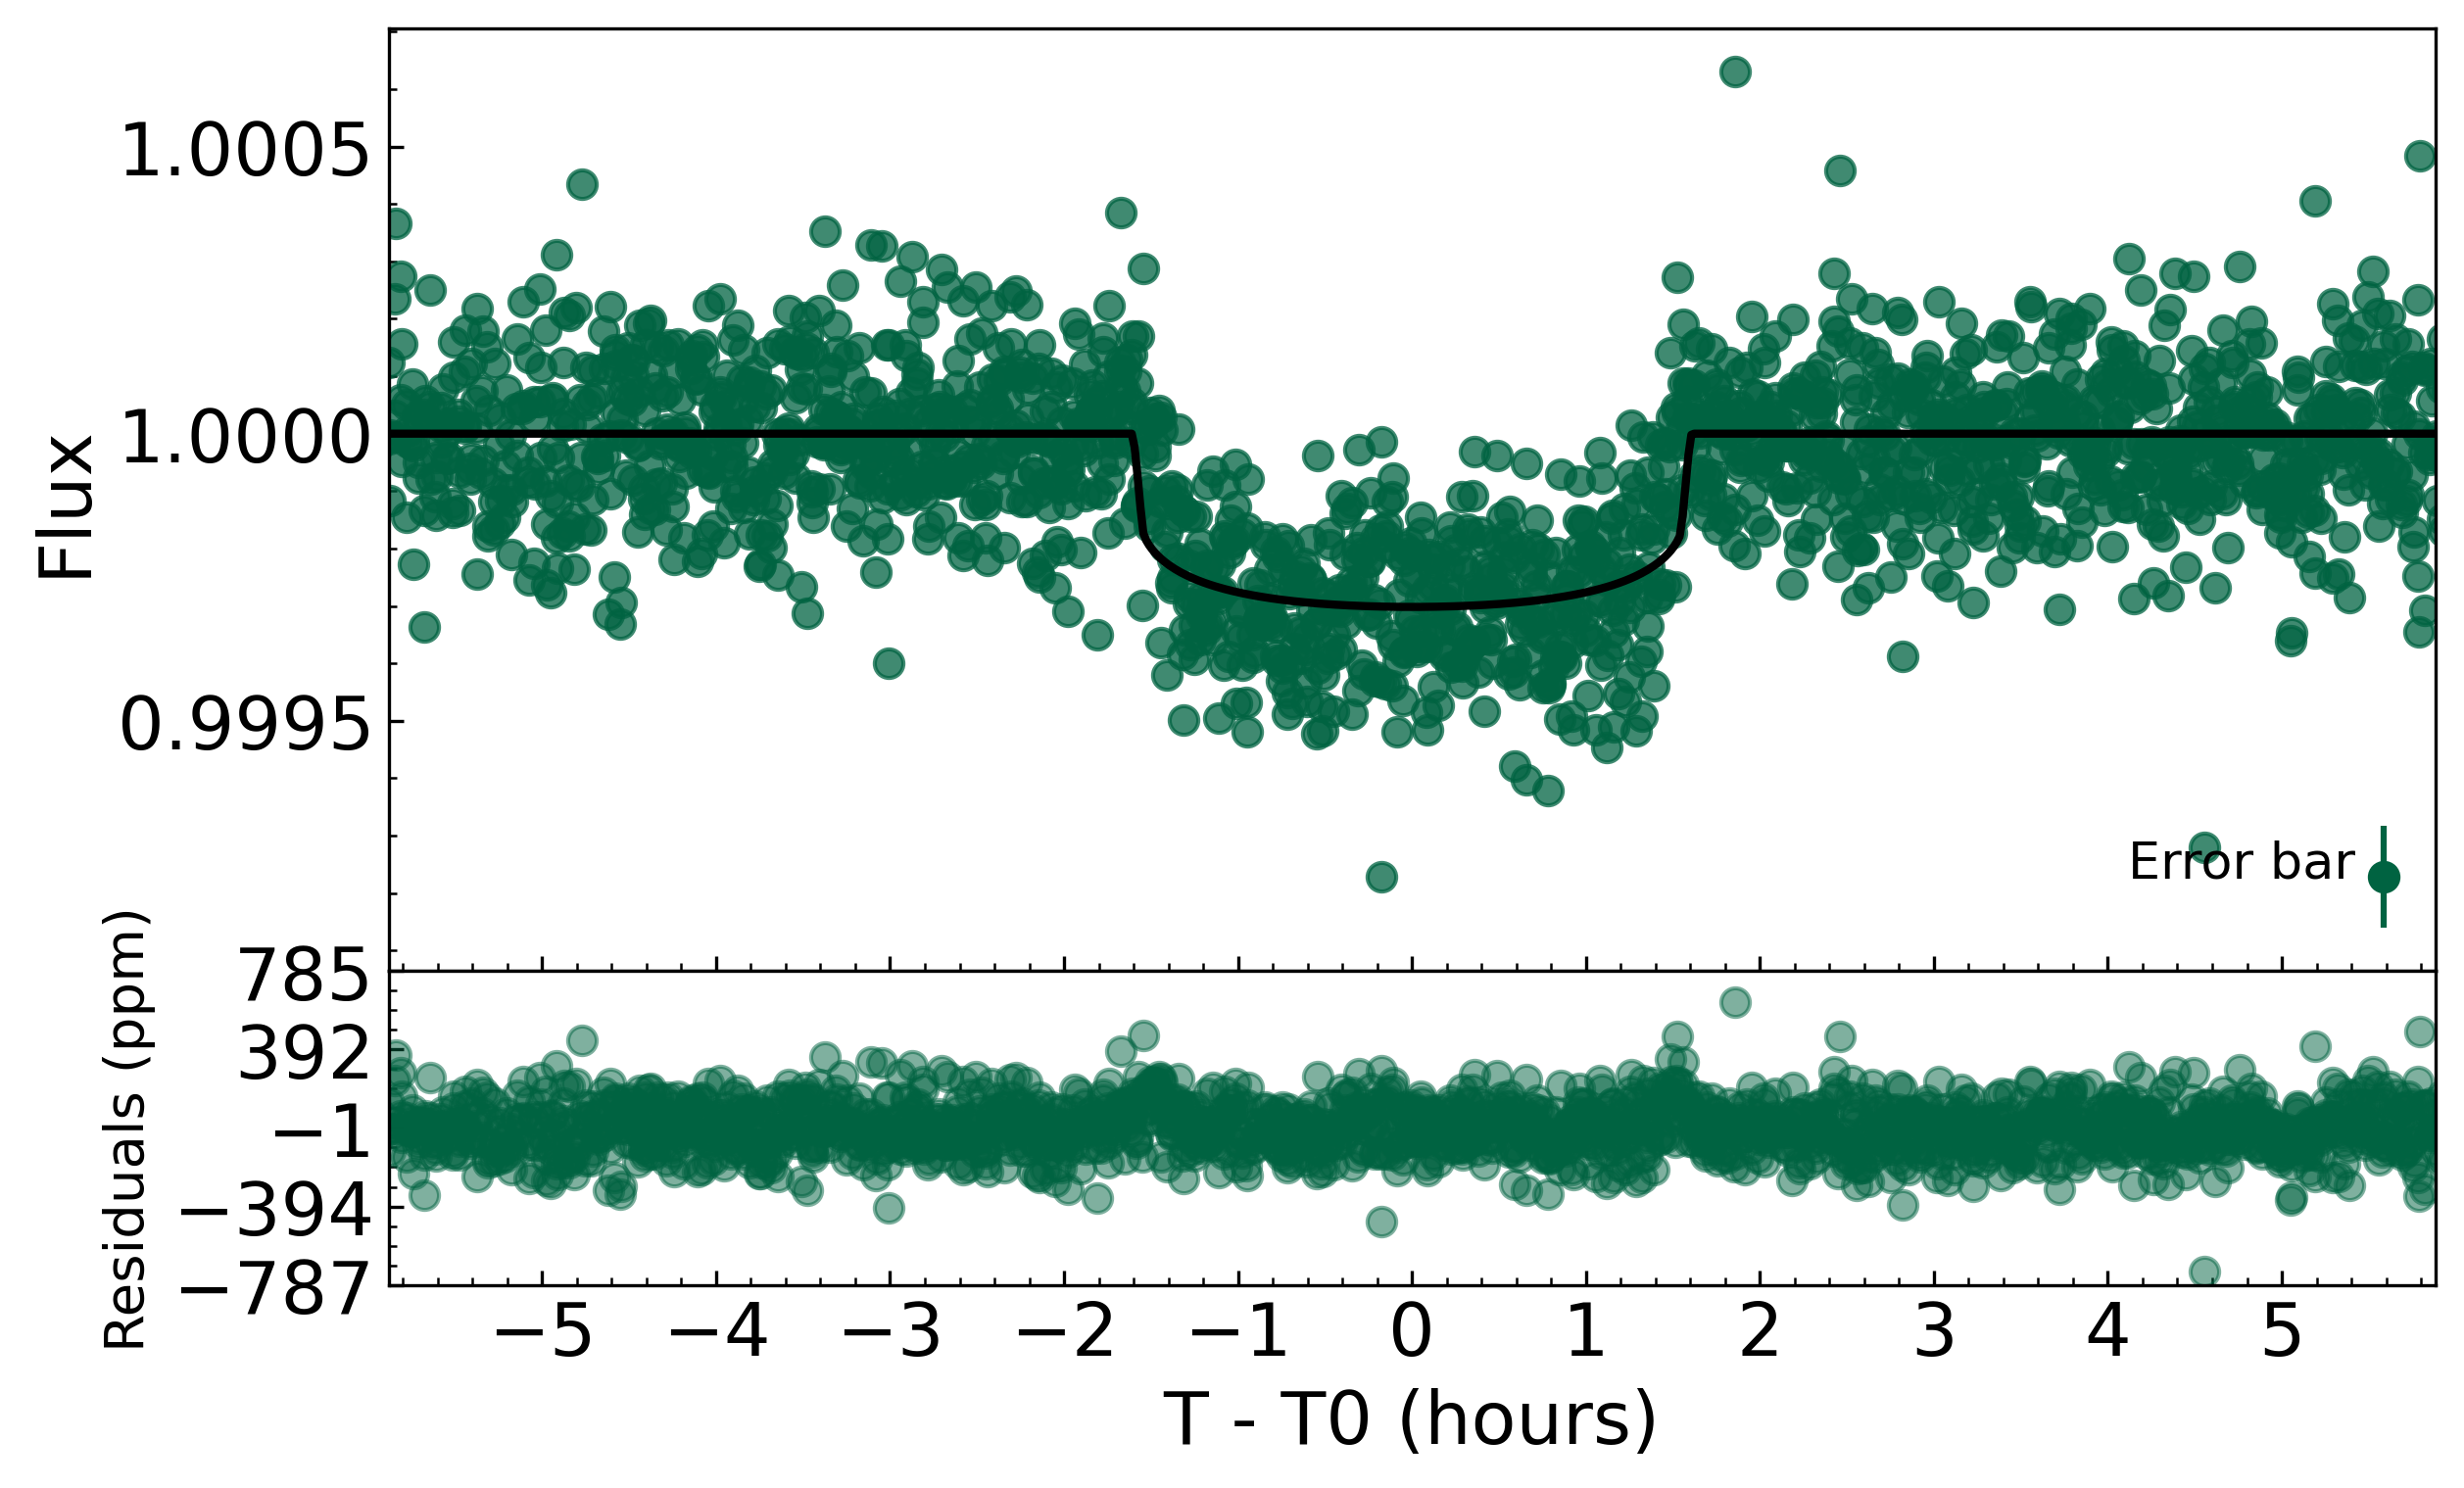

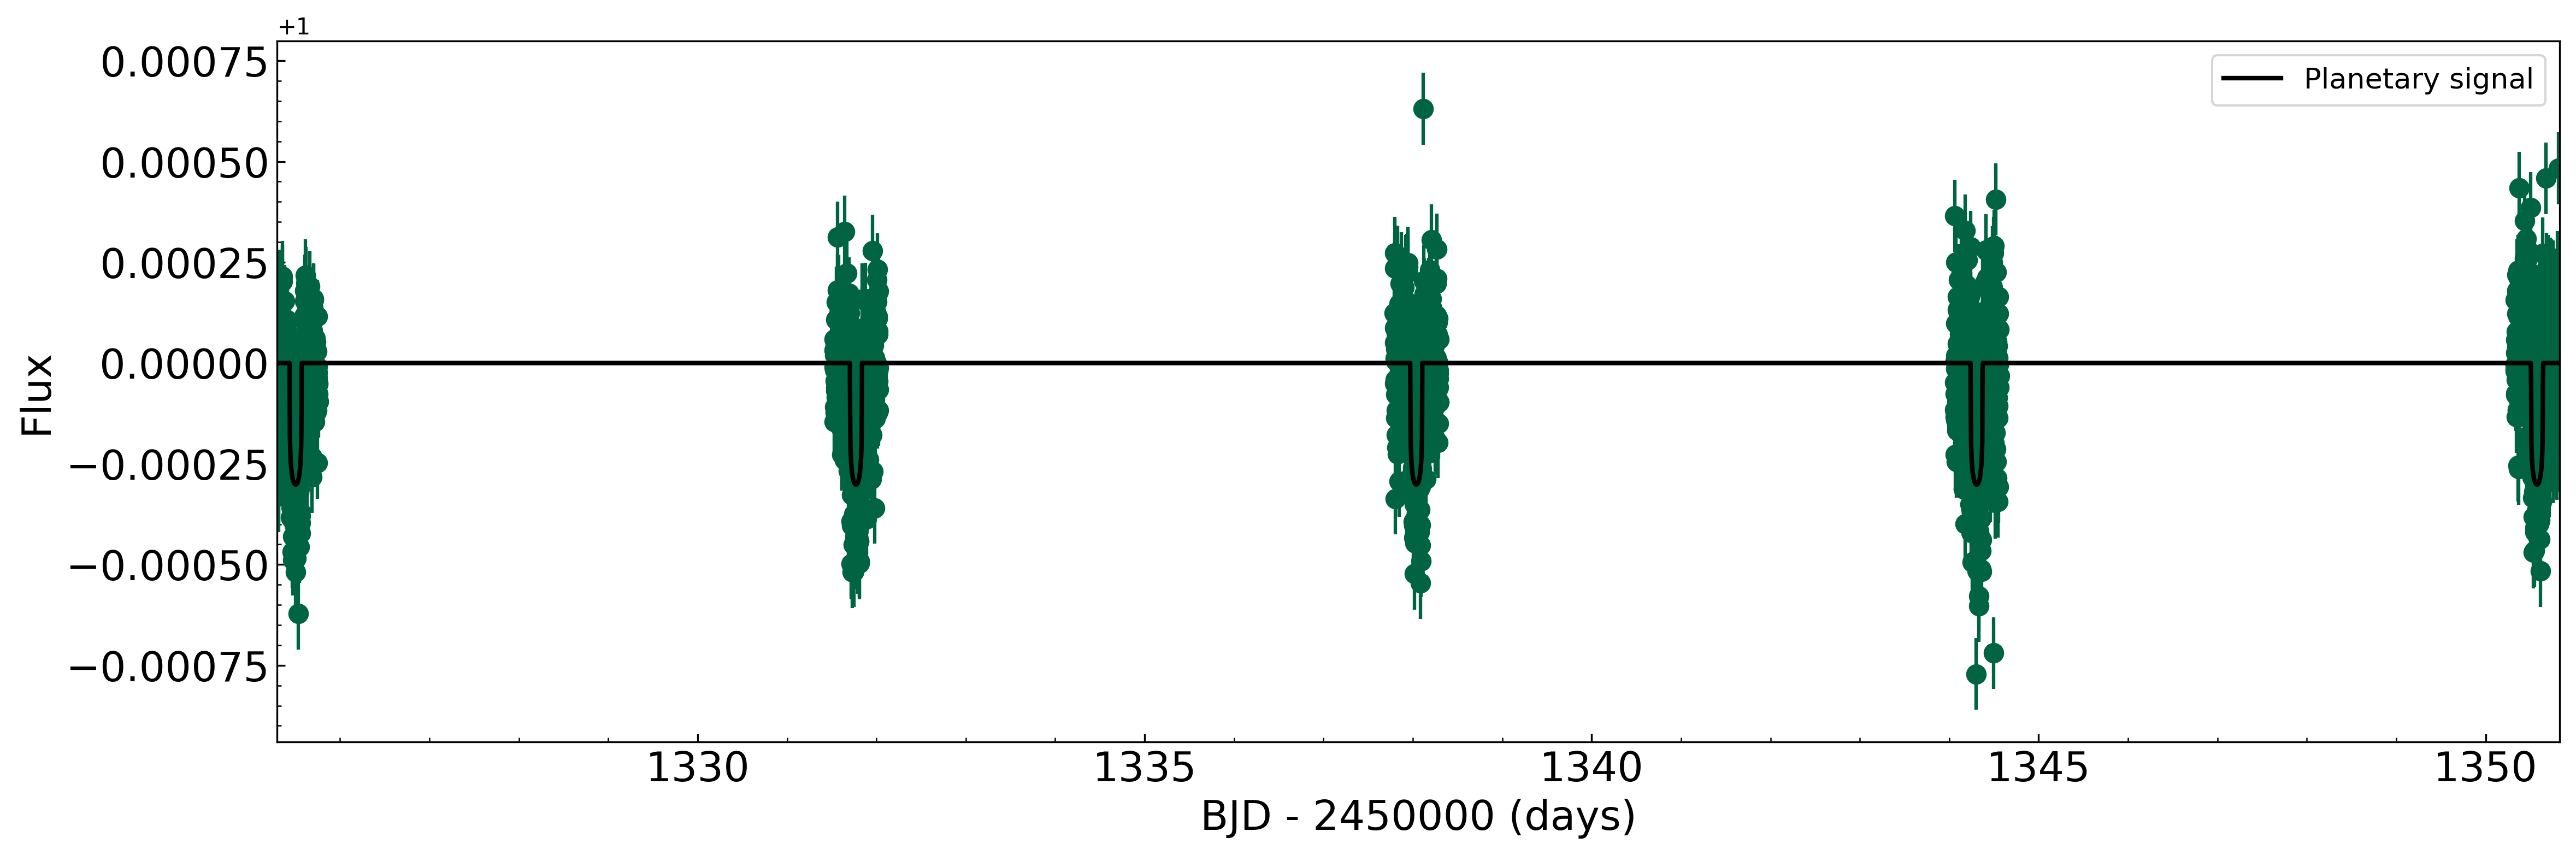

In [17]:
reload(lkep)
lkep.display_model(pti_env, 
    show_params=True, show_posterior=True, show_correlations=False, show_transits=True, show_lightcurve=True, show_chains=False)

#### Miscellaneous

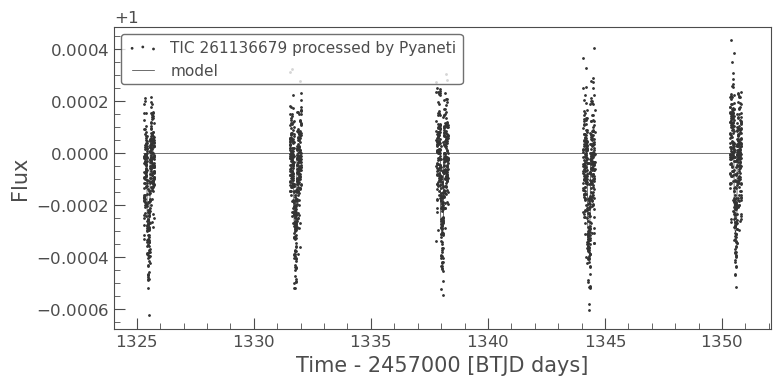

In [12]:
# read processed LC data from Pyaneti output (rather than the figures above)

from pathlib import Path
reload(lkep)

filename = Path(pti_env.target_out_dir, f"{pti_env.alias}-trdata_lightcurve.txt")
lc_tr = lkep.read_pyaneti_lc_dat(filename, time_format="btjd")

filename = Path(pti_env.target_out_dir, f"{pti_env.alias}-trmodel_lightcurve.txt")
lc_model = lkep.read_pyaneti_lc_dat(filename, time_format="btjd")

ax = lc_tr.scatter(label=f"TIC {tic} processed by Pyaneti");
ax = lc_model.plot(ax=ax, label="model");


window length:  0.45971609147318304
cadence (min):  1.9999733808799647


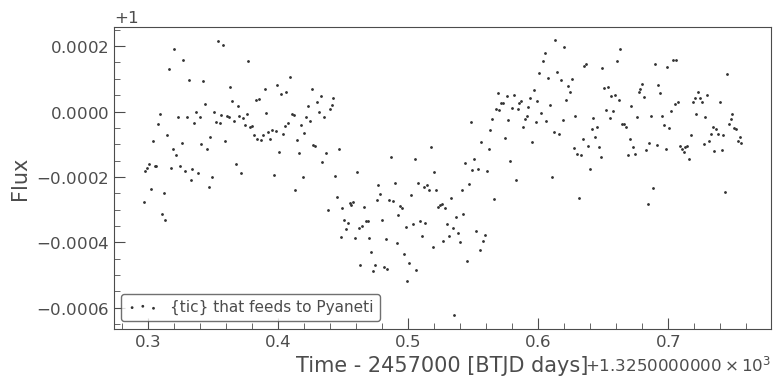

In [18]:
# original processed / truncated LC data that feeds to Pyaneti

reload(lkep)

filename = pti_env.lc_dat_filepath
lc_read = lkep.read_pyaneti_lc_dat(filename, time_format="btjd")

lc_trunc = lc_read.truncate(None, 1328)
lc_trunc.scatter(label="{tic} that feeds to Pyaneti");

print("window length: ", lc_trunc.time[-1] - lc_trunc.time[0])
print("cadence (min): ", 24 * 60 * np.nanmedian(np.diff(lc_trunc.time)))